PROBABILIDADES DE GANAR Y PERDER LOS SETS 
ARMADO DE PAREJAS
ENTRENAMIENTO
GUIA DE DATOS

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re 
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV


In [2]:
df_data = pd.read_excel("_ml_jug.xlsx")
#print(df_data.dtypes)
df_data["pts_netos"]= df_data["pts_ganados"] - df_data["NF_total"]

In [3]:
df_data.shape

(1256, 27)

In [4]:
df_data.columns

Index(['nombre', 'edad', 'alt', 'pos', 'torneo', 'set', 'saque', 'NF_total',
       'w_total', 'sm_total', 'nsmtotal', 'prec sm%', 'csm', 'fondo', 'm3',
       'm5', 'm7', 'pts_ganados', 'games_jug', 'circuito', 'fase', 'mano',
       'spcsm', 'bloc', 'partido', 'nfr', 'pts_netos'],
      dtype='object')

In [5]:
df_data =df_data[df_data["circuito"] == "WPT"] 

In [6]:
round(df_data.describe(),2)

,edad,alt,saque,NF_total,w_total,sm_total,nsmtotal,prec sm%,csm,fondo,m3,m5,m7,pts_ganados,games_jug,spcsm,bloc,nfr,pts_netos
count,1120.00,1120.00,1120.0,1120.00,1120.00,1120.00,1120.00,850.00,1120.00,1120.00,1120.00,1120.00,1120.00,1120.00,1120.00,552.00,552.00,192.00,1120.00
mean,26.73,1.81,1.5,2.02,3.49,1.65,0.86,65.21,0.36,0.23,1.09,1.76,3.67,6.52,4.73,0.45,0.17,1.58,4.49
std,5.84,0.05,0.5,1.58,2.44,1.78,1.16,33.73,0.70,0.50,1.24,1.57,2.29,3.40,0.89,0.71,0.48,1.39,3.79
min,18.00,1.67,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,-7.00
25%,23.00,1.76,1.0,1.00,2.00,0.00,0.00,50.00,0.00,0.00,0.00,1.00,2.00,4.00,4.00,0.00,0.00,0.00,2.00
50%,26.00,1.80,1.5,2.00,3.00,1.00,0.00,67.00,0.00,0.00,1.00,1.00,3.00,6.00,5.00,0.00,0.00,1.00,4.00
75%,29.00,1.85,2.0,3.00,5.00,2.00,1.00,100.00,1.00,0.00,2.00,3.00,5.00,9.00,5.00,1.00,0.00,3.00,7.00
max,47.00,1.90,2.0,9.00,13.00,9.00,7.00,100.00,6.00,3.00,9.00,9.00,15.00,17.00,6.00,3.00,3.00,6.00,17.00


In [7]:
serie_nan =df_data.isna().sum()


l_na =  [col for col in serie_nan if col != 0]

serie_nan[serie_nan.isin(l_na)]

prec sm%    270
spcsm       568
bloc        568
partido     568
nfr         928
dtype: int64

Hay valores NaN en prec sm% - esto seria la efectividad de los remates, pero como hay jugadores que no rematan en un set, para no computar un 0 en su promedio, se lo deja como Nan. Al hacer la media total de cada caracteristica, este valor va a dejar de ser Nan porque todos los jugadores remataron al menos una vez
Las ultimas 4 caracteristicas van a ser borradas del df ya que no hay de todos los jugadores, y no son importantes

## Creacion de nuevo dataframe (df)
Se va a crear un df dividiendo las caracteristicas por la cantidad de games jugados.
Se eligieron las 3 columnas mas relevantes al analizar partidos, como son los puntos por game (pxg), errores no forzados por game (nfxg) y remates por game (rem). Ademas, se creó una variable sintetica, que es el resultado de restarle a los puntos que hace por game el jugador sus errores no forzados, se llamará pts_netos

In [8]:
df_clean = pd.DataFrame()
df_clean = df_clean.assign(name = df_data["nombre"])
df_clean = df_clean.assign(pxg = df_data["pts_ganados"]/df_data['games_jug'])
df_clean= df_clean.assign(nfxg = df_data["NF_total"]/df_data['games_jug'])
df_clean = df_clean.assign(rem = (df_data["sm_total"] + df_data["nsmtotal"])/df_data['games_jug'])

#creacion de columna puntos netos
df_clean["pts_netos"] = df_clean["pxg"] - df_clean["nfxg"]

df_clean = df_clean.groupby("name")[["pxg","nfxg","pts_netos","rem"]].mean().sort_values(by="pxg", ascending=False)

df_clean1 = df_clean.reset_index(drop=True)

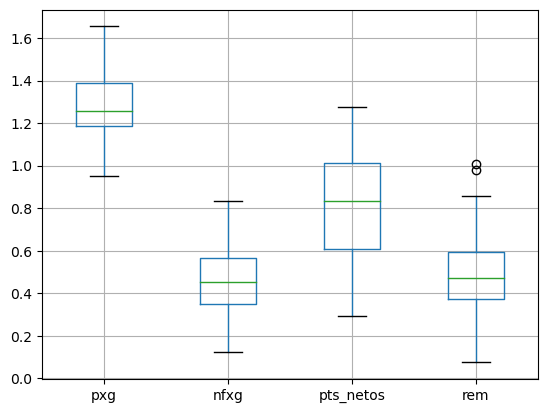

In [9]:
df_clean1.boxplot()
plt.show()

In [10]:
df_clean_val = df_clean.values

#nombre de los jugadores 
df_clean_index = df_clean.index

### Metodo del codo ver si poner esto

### Instanciar modelo

In [11]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=6)
pred_y = model.fit_predict(df_clean)

C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Preprocesado y modelado

Porcentaje de varianza explicada por cada componente
[6.13227487e-01 2.89179297e-01 9.75932161e-02 2.68604567e-32]


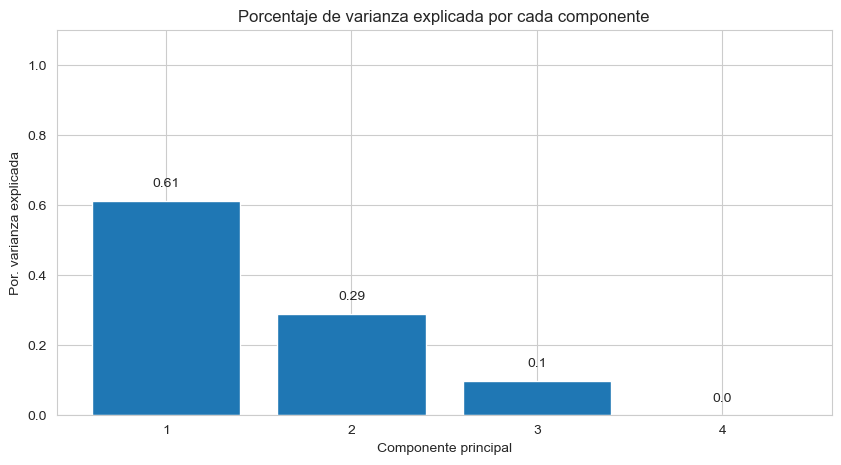

In [12]:
df_cluster =df_clean1
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_cluster)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

# Porcentaje de varianza explicada por cada componente
print('Porcentaje de varianza explicada por cada componente')
print(modelo_pca.explained_variance_ratio_)

import seaborn as sns;sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.bar(x= np.arange(modelo_pca.n_components_) + 1,height = modelo_pca.explained_variance_ratio_)
for x, y in zip(np.arange(len(df_cluster.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1);ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')
plt.show()

In [13]:
#Utilizar los 2 primeros componentes del PCA
df_pca = pd.DataFrame(data = modelo_pca.components_, columns=df_cluster.columns, 
             index = ["PC1","PC2","PC3","PC4"])

proyecciones = pca_pipe.transform(X=df_cluster)

proyecciones = pd.DataFrame(data = proyecciones,columns =  ["PC1","PC2","PC3","PC4"],
                           index = df_cluster.index)

proyecciones = proyecciones[["PC1", "PC2"]]

proyecciones.head(2)

,PC1,PC2
0,-2.432792,0.827065
1,-2.197807,1.238475


In [14]:
#Graficar clusters

#model con cluster
modelcc = model.fit(proyecciones)

#obtener labels del modelo fitteado
labels = modelcc.labels_

#agregar los labels al df
df_clean1['cluster_label'] = labels

#representamos puntos y centroides
# Obtener los Centroides
centroids = modelcc.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]


#cambiar el index por nombres de los jugadores
df_clean1.set_index(df_clean_index, inplace=True)
#print(cc1.sort_values("cluster_label"))
maskcc0 = (df_clean1['cluster_label'] == 0)
maskcc1 = (df_clean1['cluster_label'] == 1)
maskcc2 = (df_clean1['cluster_label'] == 2)


#colores
fondo = "#313332"
verde_lindo = "#46f892"
verde_claro = "#b5fdcd"
scattermedia ="#42424d" #alpha=0.9
text_color = "w"
color_set1 = '#3ff294' # gran verde
color_set2 = '#f4aa51' # amarillo arena naranja
celeste = "#31acce" 
celeste_claro = "#c1e6f0"


# Obtén las coordenadas de los puntos
x = df_clean1['pxg']
y = df_clean1['rem']
names = df_clean_index  # Nombres de los puntos



C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Los datos de cada jugador en particular por game

In [15]:
print(df_clean1.head())

cluster0 = list(df_clean1[df_clean1["cluster_label"] == 0].index)
cluster1 = list(df_clean1[df_clean1["cluster_label"] == 1].index)
cluster2 = list(df_clean1[df_clean1["cluster_label"] == 2].index)

cluster2

               pxg      nfxg  pts_netos       rem  cluster_label
name                                                            
Paquito   1.653968  0.465079   1.188889  0.649206              2
Stupa     1.617614  0.508333   1.109280  0.728220              2
Coello    1.568414  0.294758   1.273656  0.746640              2
Tapia     1.542876  0.352151   1.190726  0.630914              2
Lamperti  1.518056  0.258333   1.259722  0.676389              2


['Paquito',
 'Stupa',
 'Coello',
 'Tapia',
 'Lamperti',
 'Galan',
 'Leal',
 'Pincho',
 'Zapata']

### Grafico de los clusters

C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_10720\509888346.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.index, rotation=90)


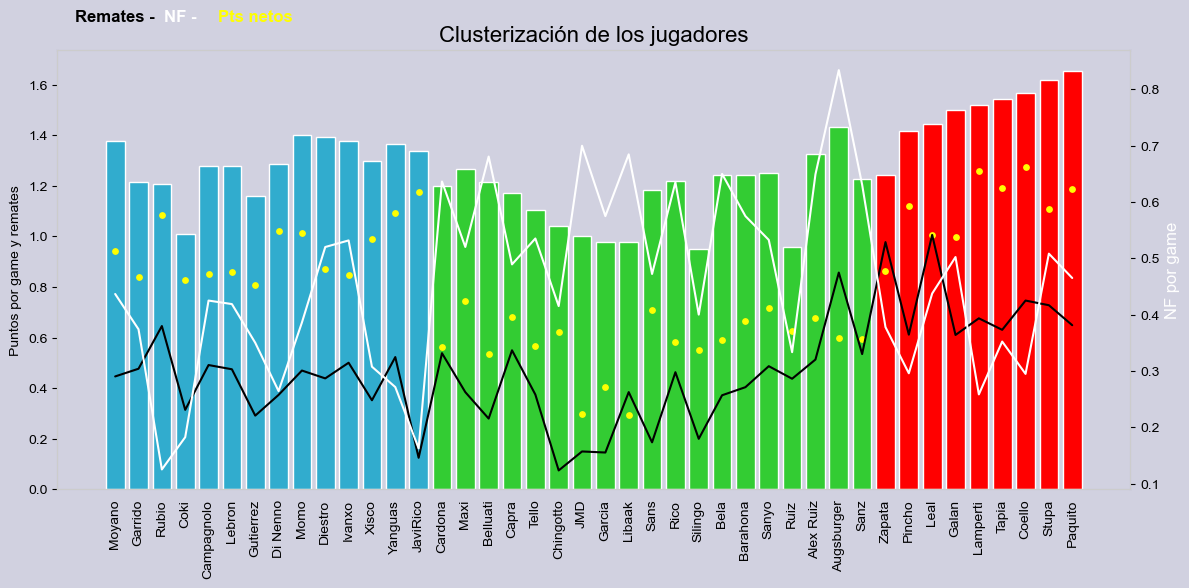

In [16]:
def g_bar(df):
    # Crea el gráfico scatter con nombres
    df= df.sort_values("cluster_label")
    
    fig, ax = plt.subplots(figsize=(12,6))
    fig.set_facecolor("#d1d1e0")
    name1 = "pts x game"
    name2 = "NF"
    name3 = "Rem"
    
    width = 0.2
    index = np.arange(3)
    
    

    verde_lindo= "#33cc33"
    
    #sns.barplot(x= df.index, y=df["rem"], hue=df["cluster_label"])
    # Define una paleta de colores personalizada
    colores = [celeste, verde_lindo, "red"]

    # Asigna colores a las barras en función de los valores de "cluster_label"
    colores_barras = [colores[label] for label in df["cluster_label"]]
    
    ax.patch.set_facecolor("#d1d1e0")
    ax.bar(df.index, df["pxg"], color=colores_barras)
    #ax.scatter(df.index, df["rem"], color ="black", s=15)
    ax.plot(df.index, df["rem"], color ="black")
    ax.scatter(df.index, df["pts_netos"], color ="yellow",s=15)
    #ax.plot(df.index, df["pts_netos"], color ="yellow")
    ax.set_xticklabels(df.index, rotation=90)
    ax.set_ylabel("Puntos por game y remates", color = "black")
    
    #compartir eje x 
    ax2 = ax.twinx()
    #ax2.scatter(df.index, df["nfxg"], color ="white",s=15) 
    ax2.plot(df.index, df["nfxg"], color ="white") 
   
    ax2.set_ylabel("NF por game", color = "white", fontsize=12)

    #cambiar colores
    ax.tick_params(axis="y", colors="black")
    ax2.tick_params(axis="y", colors="black")
    ax.tick_params(axis="x", colors="black")
   
    
    plt.title("Clusterización de los jugadores", color="black", fontsize=16)
    ax.xaxis.grid(False)  # Desactivar las líneas de la cuadrícula en el eje x
    ax.yaxis.grid(False)
    #ax.grid(False)
    ax2.grid(False)
    ax.text(0.1, 1.85, "Remates - ", color="black", weight='bold', ha='center',fontsize=12)
    ax.text(2.8, 1.85, "NF -", color="white", weight='bold', ha='center',fontsize=12)
    ax.text(6, 1.85, "Pts netos", color="yellow", weight='bold', ha='center', fontsize=12)
    
    
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
g_bar(df_clean1)

# Conclusiones de la clusterización
En el grafico de arriba se observan los 3 clusters que agrupan a los jugadores segun sus estadisticas por game que juegan; estadisticas que son un reflejo del rol del jugador o de su performance en los partidos analizados. Las barras son los puntos que hacen, linea blanca los errores no forzados y la linea negra los remates que realizan.

Descripcion de clusters:

El cluster 1 y 2 tienen como similitud rematar menos y hacer menos puntos totales que el cluster 3.

Cluster 1, celeste: son jugadores que presentan valores de puntos y remates por game intermedios entre los 3 clusters. Suelen cometer pocos errores no forzados. Por estas 2 razones es que la cantidad de puntos netos es alta. En cuanto al rol en el partido, la mayoria son jugadores que arman el juego y que tambien definen los puntos; o que definen los puntos pero no rematan tanto como el cluster 3


Cluster 2, verde: son jugadores que estadisticamente se diferencian por la alta cantidad de errores no forzados que cometen. La mayoria realiza pocos remates, aunque hay algunos jugadores que rematan frecuentemente. Son de los que menos puntos por game realizan por lo que tienen valores bajos de puntos netos. En cuanto a su rol en el partido suelen ser jugadores que arman el juego para que defina su compañero; o jugadores que no se encuentran en un alto nivel, hecho que se ve influido por la cantidad de partidos analizados y contra cual pareja jugaron.

Cluster 3, rojo: son los jugadores que de los 3 clusters realizan mas puntos y mas remates. Errores no forzados es variado, por lo que suelen tener alta cantidad de puntos netos. Su rol en el partido es de definición del punto

### Evaluacion de Silhouette

In [80]:
from sklearn.metrics import silhouette_score, silhouette_samples
valor_x = df_clean1.drop("cluster_label", axis=1).values

valor_y = df_clean1.cluster_label.values

sc = StandardScaler()
valor_x_norm =sc.fit_transform(valor_x)
slc = {}

for k in range(2,6):
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=10).fit(valor_x_norm)
    clusters =kmeans.labels_
    slc[k] = silhouette_score(valor_x_norm, clusters)
    
slc



C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with

{2: 0.3514027452904437,
 3: 0.29520723165436374,
 4: 0.30956146618489244,
 5: 0.3160703788613919}

# Graficar silhouete 

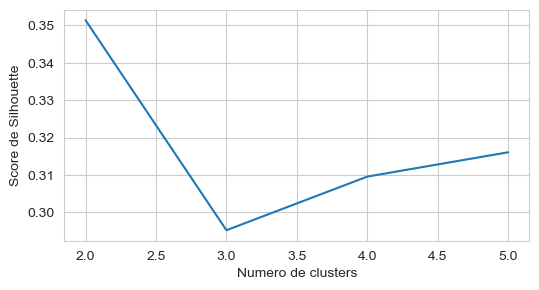

In [81]:
plt.figure(figsize=(6,3))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Numero de clusters")
plt.ylabel("Score de Silhouette")
plt.show()

# Análisis del ranking según clusters
En el grafico de arriba se observan los 3 clusters que agrupan a los jugadores segun sus estadisticas por game que juegan; estadisticas que son un reflejo del rol del jugador o de su performance en los partidos analizados. Las barras son los puntos que hacen, linea blanca los errores no forzados y la linea negra los remates que realizan.

Descripcion de clusters:

### Cluster 1, rojo: 
Son jugadores que presentan valores de puntos y remates por game intermedios entre los 3 clusters. Suelen cometer pocos errores no forzados. Por estas 2 razones es que la cantidad de puntos netos es alta. En cuanto al rol en el partido, la mayoria son jugadores que arman el juego y que tambien definen los puntos; o que definen los puntos pero no rematan tanto como el cluster 3

### Cluster 2, verde: 
Son jugadores que estadisticamente se diferencian por la alta cantidad de errores no forzados que cometen. La mayoria realiza pocos remates, aunque hay algunos jugadores que rematan frecuentemente. Son de los que menos puntos por game realizan por lo que tienen valores bajos de puntos netos. En cuanto a su rol en el partido suelen ser jugadores que arman el juego para que defina su compañero; o jugadores que no se encuentran en un alto nivel, hecho que se ve influido por la cantidad de partidos analizados y contra cual pareja jugaron.

### Cluster 3, azul: 
Son los jugadores que de los 3 clusters realizan mas puntos y mas remates. Errores no forzados es variado, por lo que suelen tener alta cantidad de puntos netos. Su rol en el partido es de definición del punto


### Parejas segun ranking:

#### Numero 1: 
Son 2 jugadores del cluster 3. Ambos estan por encima del percentilo 85 en puntos por game, única pareja que tiene a 2 jugadores con tantos puntos, y ademas son la pareja que menos errores no forzados comete. Hacen muchos puntos y otorgan pocos al rival. Como detalle no menor, tambien son los que mas rematan, teniendo una de las efectividades mas altas además. Se encuentran invictos.

#### Numero 2: 
Tiene un jugador del cluster 3 y el otro es un hibrido, cluster 2, que tiene partidos en los cuales se vuelve mas ofensivo y tiene menos errores no forzados que su compañero

#### Numero 3: 
Tiene un jugador del cluster 3 y el otro es un hibrido, cluster 2, que tiene partidos en los cuales se vuelve mas defensivo y es de los que menos errores no forzados tiene en el torneo

#### Numero 4: 
Tiene 2 jugadores hibridos, cluster 2. Uno de ellos el que mas puntos hace por game en el cluster 2 y con pocos errores no forzados. En cambio, su pareja, tiene rendimientos mas variado, sobretodo en lo que respecta a errores no forzados.

#### Numero 5: 
Tiene un jugador del cluster 3, siendo el que mas puntos hace en el torneo, y a un jugador del cluster 1, quien hace pocos puntos (los termina haciendo su compañero) y comete muy pocos errores no forzados

##### Esto denota que no hay una formula única en el armado de parejas con respecto a los roles de cada jugador

## En cuanto a las combinaciones con pocas probabilidades de exito:
Es una tentación juntar 2 jugadores que hagan muchos puntos por game, sin embargo, estos jugadores suelen estar por encima del percentilo 50 en errores no forzados, y juntar a jugadores que "compitan" por hacer puntos y se "hundan" por los errores no forzados no ha tenido buenos resultados; excepto los actuales numero 1, pero ellos comenten muy pocos errores no forzados, ambos

# Análisis por equipos

In [82]:
#dataset con los datos por equipo con resultado - df_gop (gano o perdio)
df_gop = pd.read_excel("_ml1_eqxset.xlsx")

df_gop["pts_netos"] = df_gop["pto_tot"] - df_gop["nf"]

print(df_gop.columns)
df_gop.head(2)

Index(['nombre', 'nf', 'w', 'sm', 'ns', 'prec', 'csm', 'fondo', 'm3', 'm5',
       'm7', 'pto_tot', 'tot_snf', 'ed', 'spcsm', 'bloc', 'set', 'sk_prim',
       'games jug', 'sk_oro', 'resto_oro', 'op quiebre', 'circuito', 'torneo',
       'fase', 'gano_set', 'nfr', 'partido', 'pts_netos'],
      dtype='object')


,nombre,nf,w,sm,ns,prec,csm,fondo,m3,m5,...,sk_oro,resto_oro,op quiebre,circuito,torneo,fase,gano_set,nfr,partido,pts_netos
0,Tap-Coe,2,11,3,4,43,1,4,9,11,...,100.0,NaN,100.0,WPT,Vigo,Final,g,NaN,tcvsgc,27
1,Gal-Leb,10,16,6,1,86,3,0,4,1,...,NaN,0.0,0.0,WPT,Vigo,Final,p,NaN,tcvsgc,10


In [83]:
#cambiar index 
df_gop.set_index('nombre',inplace=True)

#df con games ganados
df_gano = df_gop[df_gop["gano_set"]=="g"]
all_cols = ['nf', 'w', 'sm', 'ns', 'csm', 'fondo', 'm3', 'm5',
       'm7', 'pto_tot', 'tot_snf', 'ed','games jug', "set"]

#res_col = ["nf", "pto_tot", "tot_snf","sm","ns", "games jug"]
res_col = ["nf", "pto_tot", "pts_netos", "games jug"]


df_gano = df_gano[res_col]

df_ganoxgame = round(df_gano.div(df_gano["games jug"], axis=0),3)
df_ganoxgame["result"] ="g"


#df con games perdidos
df_perdio = df_gop[df_gop["gano_set"]=="p"]
df_perdio = df_perdio[res_col]

df_perdioxgame = round(df_perdio.div(df_perdio["games jug"], axis=0),3)
df_perdioxgame["result"] ="p"

#concatenar los df gano y perdio 

all = pd.concat([df_ganoxgame, df_perdioxgame])
all.drop("games jug", axis=1, inplace=True)
all["result"] = np.where(all["result"] == "g",1,0)
all

,nf,pto_tot,pts_netos,result
nombre,,,,
Tap-Coe,0.200,2.900,2.700,1
Tap-Coe,0.556,3.444,2.889,1
Tap-Coe,0.600,3.200,2.600,1
Momo-Sanyo,0.900,2.800,1.900,1
Tap-Coe,0.900,2.800,1.900,1
...,...,...,...,...
Tap-Coe,1.100,2.700,1.600,0
Maxi-Capra,0.750,2.625,1.875,0
Stupa-Di,1.200,2.600,1.400,0


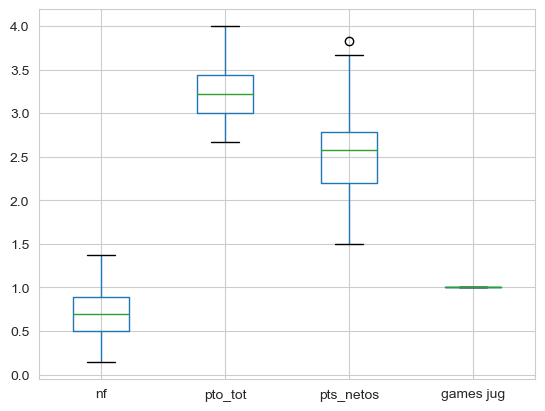

In [84]:
df_ganoxgame.boxplot()
plt.show()

               nf  pto_tot  pts_netos  games jug result
nombre                                                 
Tello-Ruiz  2.167    1.167       -1.0        1.0      p
             nf  pto_tot  pts_netos  games jug result
nombre                                               
Stupa-Di  0.444    2.556      2.111        1.0      p

nombre
Stupa-Di             0.444
Paquito-Chingotto    0.500
Garrido-Sanz         0.556
Paquito-Chingotto    0.625
Bela-Yanguas         0.667
                     ...  
Gal-Leb              1.556
Ivanxo-Cardona       1.571
Ivanxo-Cardona       1.571
Galan-Sanz           1.714
Tello-Ruiz           2.167
Name: nf, Length: 83, dtype: float64


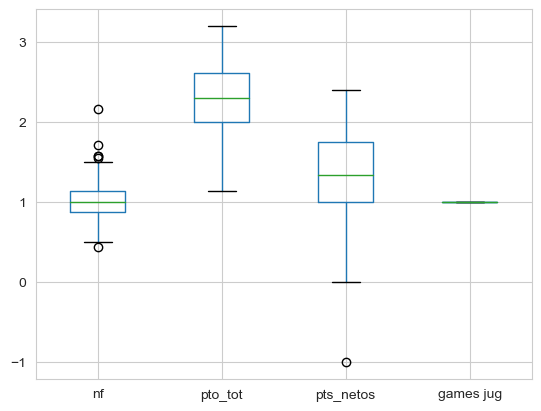

In [85]:
#identificar outlier
print(df_perdioxgame[df_perdioxgame["pts_netos"] == df_perdioxgame["pts_netos"].min()])
print(df_perdioxgame[df_perdioxgame["nf"] == df_perdioxgame["nf"].min()])
print()
print(df_perdioxgame["nf"].sort_values())
df_perdioxgame.boxplot()
plt.show()

### Buscar outliers

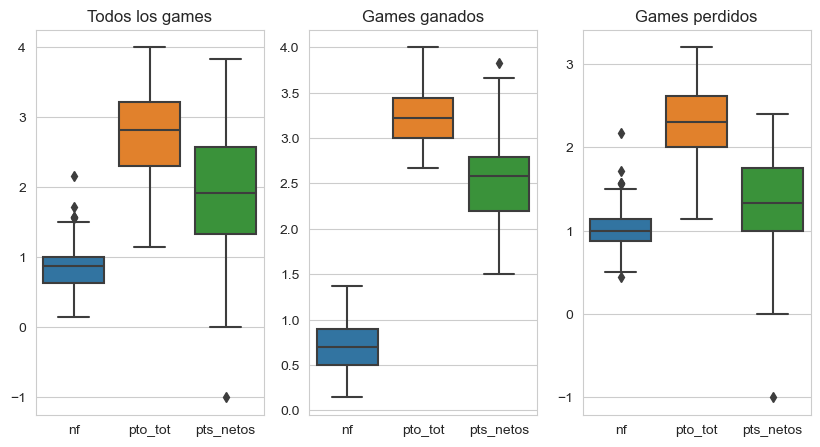

In [86]:
#all.boxplot()

boxdata1 =all[["nf", "pto_tot", "pts_netos"]]
boxdata2 =df_ganoxgame[["nf", "pto_tot", "pts_netos"]]
boxdata3 =df_perdioxgame[["nf", "pto_tot", "pts_netos"]]

fig, ax = plt.subplots(1,3, figsize=(10,5))
sns.boxplot(data=boxdata1, ax=ax[0])
ax[0].set_title("Todos los games")
sns.boxplot(data=boxdata2, ax=ax[1])
ax[1].set_title("Games ganados")
sns.boxplot(data=boxdata3, ax=ax[2])
ax[2].set_title("Games perdidos")
                            
plt.show()

In [87]:
### Valores atipicos en el dataframe perdioxgame nf y pts_netos

In [88]:
#Calculo para ver si es outlier el minimo en nf

# Calcular el primer cuartil (Q1)
q1 = np.quantile(df_perdioxgame["nf"], 0.25)

# Calcular el tercer cuartil (Q3)
q3 = np.quantile(df_perdioxgame["nf"], 0.75)

# Calcular la diferencia intercuartílica (IQR)
iqr = q3 - q1


# Calcular el límite inferior para valores atípicos
lower_bound = q1 - 1.5 * iqr

print("No forzados límite inferior para valores atípicos:", lower_bound)


No forzados límite inferior para valores atípicos: 0.473


In [89]:
#Calculo para ver si es outlier el maximo en tot_snf
# Calcular el primer cuartil (Q1)
qq1 = np.quantile(df_perdioxgame["pts_netos"], 0.25)

# Calcular el tercer cuartil (Q3)
qq3 = np.quantile(df_perdioxgame["pts_netos"], 0.75)

# Calcular la diferencia intercuartílica (IQR)
iqr2 = qq3 - qq1

# Calcular el límite inferior para valores atípicos
super_bound_snf = qq1 - 1.5 * iqr2

print("Puntos netos límite inferior para valores atípicos:", super_bound_snf)

Puntos netos límite inferior para valores atípicos: -0.125


Stupa-Di  0.778      3.0    2.556        1.0      p
             nf  pto_tot  tot_snf  games jug result
nombre                                             
Stupa-Di  0.444    2.556    1.667        1.0      p

In [90]:
mask1 = (all["nf"] == 0.444) & (all["pto_tot"] == 2.556) & (all["result"] == 0)
mask2 = (all["pts_netos"] < super_bound_snf) & (all["result"] == 0)
print(all.shape)
all = all[~(mask1 | mask2)]
print(all.shape)

(166, 4)
(164, 4)


Se eliminan los 2 outliers. En uno de ellos, el game fue muy parejo, en el cuale la pareja que perdió hizo pocos errores no forzados en un game. Y en el otro los puntos netos le dieron negativo porque hicieron pocos puntos y muchos errorez no forzados

In [91]:
df_corr = all.corr()
df_corr.drop(["nf","pto_tot","pts_netos"], axis=1)

,result
nf,-0.536903
pto_tot,0.784272
pts_netos,0.775189
result,1.000000


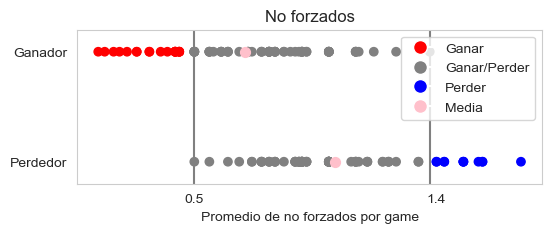

In [92]:
#errores no forzados
lim_min = all[all["result"] == 0]["nf"].min()
lim_max = all[all["result"] == 1]["nf"].max()
colors = all["nf"].apply(lambda x: 'grey' if lim_min <= x <= lim_max else 'blue' if x > lim_max else 'red')

plt.figure(figsize=(6, 2))
plt.scatter(all["nf"], all["result"], color=colors)
plt.title("No forzados")
plt.yticks([0,1],["Perdedor","Ganador"])
plt.xticks([round(lim_min,1),round(lim_max,1)])
plt.xlabel("Promedio de no forzados por game")
plt.margins(y=0.2)  # Ajusta el margen vertical

legend_labels = ['Ganar', 'Ganar/Perder', 'Perder', "Media"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red', 'grey', 'blue',"pink"]]


plt.axvline(x= lim_min, color= "grey")
plt.axvline(x= lim_max, color= "grey")
mean_nfp = all[all["result"] == 0]["nf"].mean()
mean_nfg = all[all["result"] == 1]["nf"].mean()

plt.scatter(mean_nfp, 0, color='pink', s=50, label='Media', zorder=3)
plt.scatter(mean_nfg, 1, color='pink', s=50, label='Media', zorder=3)
plt.grid(False)
plt.legend(legend_handles, legend_labels, loc='upper right')
plt.show()

Se observa que hacer muy pocos errores no forzados (lo cual no es nada sencillo y suele ocurrrir cuando hay mucha diferencia en el ranking o una pareja en particular que son los numero 1 del ranking) es un buen predictor del triunfo del set.

Los errores no forzados tienen una correlacion con el resultado de: -0.522001, siendo que quien haga mas de 
estos tiene mas probabilidades de perder. Como se aprecia en el grafico, hay un rango de 0.5 a 1.35 puntos 
en los cuales se puede ganar o perder el set

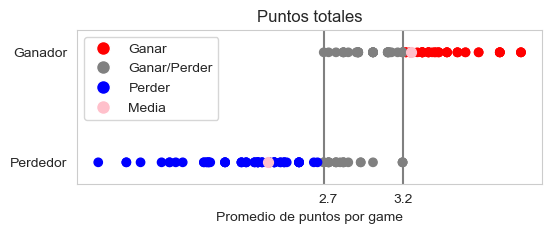

In [93]:
#Puntos totales 
lim_minpto = all[all["result"] == 1]["pto_tot"].min()
lim_maxpto = all[all["result"] == 0]["pto_tot"].max()
colors = all["pto_tot"].apply(lambda x: 'grey' if lim_minpto <= x <= lim_maxpto else 'red' if x > lim_maxpto else 'blue')

plt.figure(figsize=(6, 2))
plt.scatter(all["pto_tot"], all["result"], color=colors)
plt.title("Puntos totales")
plt.yticks([0,1],["Perdedor","Ganador"])
plt.xticks([round(lim_minpto,1),lim_maxpto])
plt.xlabel("Promedio de puntos por game")
plt.margins(y=0.2)  # Ajusta el margen vertical

legend_labels = ['Ganar', 'Ganar/Perder', 'Perder', "Media"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red', 'grey', 'blue',"pink"]]
plt.legend(legend_handles, legend_labels, loc='upper left')
plt.axvline(x= lim_minpto, color= "grey")
plt.axvline(x= lim_maxpto, color= "grey")
mean_pp = all[all["result"] == 0]["pto_tot"].mean()
mean_pg = all[all["result"] == 1]["pto_tot"].mean()

plt.scatter(mean_pp, 0, color='pink', s=50, label='Media', zorder=3)
plt.scatter(mean_pg, 1, color='pink', s=50, label='Media', zorder=3)
plt.grid(False)
plt.show()

En el grafico se puede apreciar a simple vista que los ganadores del set suelen hacer mas puntos por set
de promedio. Hay partidos muy parejos en los cuales los perdedores han hecho mas de 2.6 puntos por set. Se puede intuir que para ganar hay que promediar mas de 2.6 puntos por game

1.2715308641975307 2.56878313253012


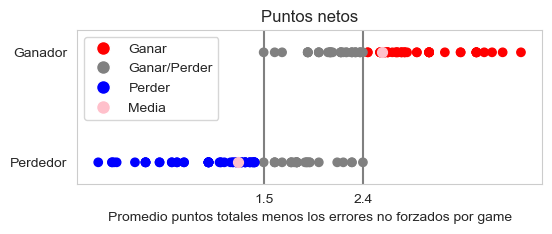

In [94]:
#Puntos netos, que sria los puntos totales menos los erroes no forzados que cometio 

#cantidad minima de puntos sin no forzados para ganar
lim_minsnf = all[all["result"] == 1]["pts_netos"].min()

#cantidad maxima de puntos sin no forzados rivales cuando se pierde
lim_maxsnf = all[all["result"] == 0]["pts_netos"].max()
colors = all["pts_netos"].apply(lambda x: 'grey' if lim_minsnf <= x <= lim_maxsnf else 'red' if x > lim_maxsnf else 'blue')

plt.figure(figsize=(6, 2))
plt.scatter(all["pts_netos"], all["result"], color=colors)
plt.title("Puntos netos")
plt.yticks([0,1],["Perdedor","Ganador"])
plt.xticks([lim_minsnf,lim_maxsnf])
plt.xlabel("Promedio puntos totales menos los errores no forzados por game")
plt.margins(y=0.2)  # Ajusta el margen vertical

legend_labels = ['Ganar', 'Ganar/Perder', 'Perder',"Media"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red', 'grey', 'blue',"pink"]]
plt.legend(legend_handles, legend_labels, loc='upper left')
plt.axvline(x= lim_minsnf, color= "grey")
plt.axvline(x= lim_maxsnf, color= "grey")
mean_pnp = all[all["result"] == 0]["pts_netos"].mean()
mean_png = all[all["result"] == 1]["pts_netos"].mean()
print(mean_pnp, mean_png)
plt.scatter(mean_pnp, 0, color='pink', s=50, label='Media', zorder=3)
plt.scatter(mean_png, 1, color='pink', s=50, label='Media', zorder=3)
plt.grid(False)
plt.show()

Teniendo en cuenta que para ganar el set, hay que promediar 2.4 puntos por game como minimo, equipos
que promedien mas de 2.4 puntos sin errores no forzados, ganan el partido el 100% de las veces, ya que
a los puntos que hacen hay que sumarle los puntos de los errores no forzados del rival

# Estadistica

In [95]:

#Puntos sin no forzados rivales
lim_minsnf = all[all["result"] == 1]["pts_netos"].min() #inicio de zona gris
lim_maxsnf = all[all["result"] == 0]["pts_netos"].max() #fin de zona gris

#Puntos totales
lim_minpto = all[all["result"] == 1]["pto_tot"].min() #inicio de zona gris
lim_maxpto = all[all["result"] == 0]["pto_tot"].max() #fin de zona gris


#errores no forzados
lim_minnf = all[all["result"] == 0]["nf"].min() #inicio zona gris
lim_maxnf = all[all["result"] == 1]["nf"].max() #fin de zona gris

mean_nfp = all[all["result"] == 0]["nf"].mean()
mean_nfg = all[all["result"] == 1]["nf"].mean()

In [96]:
#agrupar por equipos
all_equipos = all.reset_index().groupby("nombre")["pto_tot","pts_netos","nf"].mean()
#print(all_equipos)


#equipo con chances de ganar o perder: nf < lim_minnf, pto_tot > lim_minpto, tot_snf > lim_minsnf 

eq_chances_gyp = (all_equipos["nf"] < lim_maxnf) & (all_equipos["pto_tot"] > lim_minpto) & (all_equipos["pts_netos"]>lim_minnf)
all_equipos[eq_chances_gyp].sort_values(["pto_tot"], ascending=False)

C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\315617003.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_equipos = all.reset_index().groupby("nombre")["pto_tot","pts_netos","nf"].mean()


,pto_tot,pts_netos,nf
nombre,,,
Stupa-Di,3.167367,2.400600,0.766800
Tap-Coe,3.160270,2.492054,0.668351
Moyano-Xisco,2.844500,2.255500,0.589250
Paquito-Chingotto,2.790222,1.908556,0.881833
Gal-Leb,2.776364,1.785273,0.991182
Leal-Bel,2.766500,1.775000,0.991500


In [97]:
df_data.head()

,nombre,edad,alt,pos,torneo,set,saque,NF_total,w_total,sm_total,...,pts_ganados,games_jug,circuito,fase,mano,spcsm,bloc,partido,nfr,pts_netos
0,Bela,43,1.80,izq,abu_d,set1,1,2,4,2,...,7,5,WPT,Cuartos,der,NaN,NaN,NaN,NaN,5
1,Sanyo,38,1.75,der,abu_d,set1,1,4,6,4,...,11,5,WPT,Cuartos,der,NaN,NaN,NaN,NaN,7
2,Bela,43,1.80,izq,abu_d,set2,1,4,2,0,...,3,5,WPT,Cuartos,der,NaN,NaN,NaN,NaN,-1
3,Sanyo,38,1.75,der,abu_d,set2,1,3,2,1,...,3,5,WPT,Cuartos,der,NaN,NaN,NaN,NaN,0
4,Bela,43,1.80,izq,abu_d,set1,2,3,1,0,...,1,4,WPT,Cuartos,der,NaN,NaN,NaN,NaN,-2


In [98]:
#agregar cluster labels


In [99]:
df_izq = df_data[df_data["pos"]== "izq"]
df_der = df_data[df_data["pos"]== "der"]

lista_col = ["nombre","pts_ganados","NF_total","pts_netos","games_jug"]
izq_g = df_izq.groupby(["nombre"])[lista_col].mean()
der_g = df_der.groupby(["nombre"])[lista_col].mean()

for col in der_g.columns:
    izq_g[col] = izq_g[col]/izq_g["games_jug"]
    der_g[col] = der_g[col]/der_g["games_jug"]

nombres_izq = df_izq["nombre"].unique()
nombres_der = df_der["nombre"].unique()

print(nombres_izq)
nombres_der



['Bela' 'Galan' 'Ivanxo' 'Tapia' 'Moyano' 'Lamperti' 'Gutierrez'
 'Augsburger' 'Maxi' 'Stupa' 'Pincho' 'Silingo' 'Zapata' 'Momo' 'Garrido'
 'Ruiz' 'Paquito' 'Tello' 'Leal' 'Coki' 'Garcia']


array(['Sanyo', 'Lebron', 'Cardona', 'Coello', 'Xisco', 'Belluati',
       'Capra', 'Libaak', 'Campagnolo', 'Di Nenno', 'Diestro', 'JMD',
       'Sans', 'Yanguas', 'Rico', 'Chingotto', 'Rubio', 'Alex Ruiz',
       'Sanz', 'JaviRico', 'Barahona'], dtype=object)

### Crear nuevo dataframe con la combinacion de todos los jugadores separando por posicion (izquierda-derecha)

In [100]:
df_newpar =pd.DataFrame()

for par_izq in nombres_izq:
    i = 1
    for par_der in nombres_der:
        df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
        #df_newpar["pts_ganados"]= izq_g.loc[par_izq,"pts_ganados"] + der_g.loc[par_der,"pts_ganados"]
        i +=1

df_newpar.T
    

C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_15396\1319022292.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

,pts_ganados,NF_total,pts_netos,games_jug
Bela-Sanyo,2.504826,1.164093,1.340734,2.0
Bela-Lebron,2.519461,1.068007,1.451454,2.0
Bela-Cardona,2.441176,1.245798,1.195378,2.0
Bela-Coello,2.810606,0.940837,1.869769,2.0
Bela-Xisco,2.529570,0.954685,1.574885,2.0
...,...,...,...,...
Garcia-Rubio,2.202381,0.721429,1.480952,2.0
Garcia-Alex Ruiz,2.288447,1.194379,1.094067,2.0
Garcia-Sanz,2.231451,1.210963,1.020487,2.0
Garcia-JaviRico,2.246499,0.747899,1.498599,2.0


In [101]:
df_newpar =df_newpar.T

print(df_newpar.shape)
df_newpar.head(2)


(441, 4)


,pts_ganados,NF_total,pts_netos,games_jug
Bela-Sanyo,2.504826,1.164093,1.340734,2.0
Bela-Lebron,2.519461,1.068007,1.451454,2.0


In [102]:
eq_chances_gyp = (df_newpar["NF_total"] < lim_maxnf) & (df_newpar["pts_ganados"] > lim_minpto) & (df_newpar["pts_netos"]>lim_minnf)
                                                                                         
                                                                                        
mas_prob = df_newpar[eq_chances_gyp]
                                                                                         

print(mas_prob.loc["Tapia-Coello"])    
mas_prob[["pts_ganados","NF_total","pts_netos"]]




pts_ganados    3.095960
NF_total       0.653199
pts_netos      2.442761
games_jug      2.000000
Name: Tapia-Coello, dtype: float64


,pts_ganados,NF_total,pts_netos
Bela-Coello,2.810606,0.940837,1.869769
Galan-Sanyo,2.776804,1.015741,1.761063
Galan-Lebron,2.791439,0.919655,1.871784
Galan-Cardona,2.713154,1.097447,1.615708
Galan-Coello,3.082584,0.792485,2.290099
...,...,...,...
Leal-Rubio,2.691860,0.568605,2.123256
Leal-Alex Ruiz,2.777926,1.041555,1.736371
Leal-Sanz,2.720930,1.058140,1.662791
Leal-JaviRico,2.735978,0.595075,2.140903


# Machine learning

In [103]:
def entrenar(df_):
    xx = df_[df_.columns[:-1]].values
    yy = df_[df_.columns[-1]].values
    
    return xx, yy
xx, yy = entrenar(all)

x_train, x_test, y_train, y_test = train_test_split(xx,yy, test_size=0.2, random_state=45, stratify=yy)


In [104]:
#fxnes optimas

In [105]:
print(all.head())
all.result.unique()

               nf  pto_tot  pts_netos  result
nombre                                       
Tap-Coe     0.200    2.900      2.700       1
Tap-Coe     0.556    3.444      2.889       1
Tap-Coe     0.600    3.200      2.600       1
Momo-Sanyo  0.900    2.800      1.900       1
Tap-Coe     0.900    2.800      1.900       1


array([1, 0])

In [106]:

#elegir modelo, calibramos al svm y decisiontree que son los que necesitan de calibracion par aprobabilidades

lg = LogisticRegression()
svm_model = SVC(kernel='linear', probability=True) #support vector machine
svm_cal = CalibratedClassifierCV(svm_model)
nb = GaussianNB() #naibes
dt = DecisionTreeClassifier(max_depth=3, random_state=1, criterion ="gini")
dt_cal =  CalibratedClassifierCV(dt)
#bag_class= BaggingClassifier(base_estimator=knn, n_estimators=300, n_jobs=-1)




mejor_modelo = None
mejor_puntaje = 0
dicc_prec = {}
list_model = {"lg":lg, "svm":svm_cal, "nb":nb,"dt":dt_cal} #, "bagging":bag_class

for key, modelo in list_model.items():
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    #obtenemos el puntaje
    puntaje = accuracy_score(y_test, y_pred)
    dicc_prec[key] = puntaje
    
    if puntaje > mejor_puntaje:
        mejor_puntaje = puntaje
        mejor_modelo = modelo
        
#gridsearch
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'penalty': ['l1', 'l2'],  # Tipo de regularización (L1 o L2)
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']  # Algoritmo de optimización
}

grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train,y_train)
print(f"""
Mejores parametros: {grid_search.best_params_}
"Mejor CV score: {grid_search.best_score_}
Accuracy del modelo: {round(accuracy_score(y_test, grid_search.predict(x_test)),2)}
""")

        
#tenemos el modelo con el mejor accuracy_Score, que es la variable: mejor_modelo, asi que ahora se entrena
mejor_modelo.fit(x_train, y_train)
y_pred2 = mejor_modelo.predict(x_test)
y_predict = mejor_modelo.predict_proba(x_test).round(3)

print(dicc_prec)

C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: Con


Mejores parametros: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
"Mejor CV score: 0.915954415954416
Accuracy del modelo: 0.94

{'lg': 0.9393939393939394, 'svm': 0.9090909090909091, 'nb': 0.9090909090909091, 'dt': 0.9090909090909091}


C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_metho

In [107]:
print("El modelo con el mayor puntaje es:", mejor_modelo, round(mejor_puntaje,2))

El modelo con el mayor puntaje es: LogisticRegression() 0.94


In [108]:
mejor_modelo2 = LogisticRegression(C=100, penalty='l2', solver='liblinear')
mejor_modelo2.fit(x_train, y_train)
y_pred3 = mejor_modelo2.predict(x_test)

accuracy_score(y_test, y_pred3)

0.9393939393939394

In [109]:
print(classification_report(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.94      0.94      0.94        17

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33

0.9393939393939394


### Cross validation

In [110]:
from sklearn.model_selection import cross_val_score


#nivel_acc

mse_cv = cross_val_score(mejor_modelo, x_train, y_train,cv=10, scoring='accuracy') # 'accuracy', 'precision', 'recall', 'f1', 
#print(mse_cv)
mse_cv.mean()

0.9230769230769231

### Predecir nuevos datos

In [111]:
#probar con nuevo df
print(all.head(2))
df_newpar = df_newpar[["NF_total", "pts_ganados","pts_netos"]]
df_newpar.head(2)
val_df_newpar = df_newpar.values
print(val_df_newpar)

            nf  pto_tot  pts_netos  result
nombre                                    
Tap-Coe  0.200    2.900      2.700       1
Tap-Coe  0.556    3.444      2.889       1
[[1.16409266 2.50482625 1.34073359]
 [1.06800684 2.51946108 1.45145423]
 [1.24579832 2.44117647 1.19537815]
 ...
 [1.21096346 2.23145072 1.02048726]
 [0.74789916 2.2464986  1.49859944]
 [1.14285714 2.19047619 1.04761905]]


In [112]:
y = mejor_modelo.predict_proba(val_df_newpar).round(3)
prob_predict = y[:,1]


df_newpar

,NF_total,pts_ganados,pts_netos
Bela-Sanyo,1.164093,2.504826,1.340734
Bela-Lebron,1.068007,2.519461,1.451454
Bela-Cardona,1.245798,2.441176,1.195378
Bela-Coello,0.940837,2.810606,1.869769
Bela-Xisco,0.954685,2.529570,1.574885
...,...,...,...
Garcia-Rubio,0.721429,2.202381,1.480952
Garcia-Alex Ruiz,1.194379,2.288447,1.094067
Garcia-Sanz,1.210963,2.231451,1.020487
Garcia-JaviRico,0.747899,2.246499,1.498599


In [113]:
df_predict = df_newpar

# Crear un nuevo DataFrame con dos columnas "Probabilidad_1" y "Probabilidad_2"
#df_probabilidad = pd.DataFrame(y.reshape(1, -1), columns=['Probabilidad_1', 'Probabilidad_2'])

#df_predict['Probabilidad_1'] = y[0][0]

df_predict["probabilidad"] = prob_predict


#df_predict.loc[r"Tapia-Coello"]

mask_pred = df_predict["probabilidad"] >= 0.60
print(df_predict.shape)
mayor_prob60 = df_predict[mask_pred].sort_values("probabilidad",ascending=False)
print(mayor_prob60.shape)
mayor_prob60




(441, 4)
(40, 4)


,NF_total,pts_ganados,pts_netos,probabilidad
Lamperti-Coello,0.572173,3.092864,2.520691,0.887
Paquito-Coello,0.764272,3.184202,2.419930,0.877
Tapia-Coello,0.653199,3.095960,2.442761,0.865
Stupa-Coello,0.816407,3.147830,2.331422,0.840
Pincho-Coello,0.594590,2.984335,2.389745,0.816
Galan-Coello,0.792485,3.082584,2.290099,0.805
Momo-Coello,0.672026,2.991904,2.319878,0.789
Leal-Coello,0.716584,3.002467,2.285882,0.777
Lamperti-Yanguas,0.573044,2.900074,2.327030,0.761
Lamperti-JaviRico,0.450664,2.826376,2.375712,0.759


In [114]:
#mayor prob que 3ero ranking
mask_pred43 = df_predict["probabilidad"] >= 0.43

mayor_prob43 = df_predict[mask_pred43].sort_values("probabilidad",ascending=False)
print(mayor_prob43.shape)
mayor_prob43

(97, 4)


,NF_total,pts_ganados,pts_netos,probabilidad
Lamperti-Coello,0.572173,3.092864,2.520691,0.887
Paquito-Coello,0.764272,3.184202,2.419930,0.877
Tapia-Coello,0.653199,3.095960,2.442761,0.865
Stupa-Coello,0.816407,3.147830,2.331422,0.840
Pincho-Coello,0.594590,2.984335,2.389745,0.816
...,...,...,...,...
Paquito-Sanz,1.105827,2.902665,1.796838,0.434
Stupa-Alex Ruiz,1.141378,2.923289,1.781911,0.434
Moyano-Xisco,0.774194,2.709677,1.935484,0.433
Paquito-Barahona,1.037721,2.861691,1.823970,0.432


In [115]:
#mayor_prob43
pat1 = r"\w+-Coello"
coello_sum = 0
pat2 = r"Tapia-\w+"
tapia_sum=0
pat3 = r"Paquito-\w+"
paquito_sum=0
pat4= r"Galan-\w+"
gal_sum =0
pat5= r"Stupa-\w+"
stu_sum =0

for i in mayor_prob43.index:
    if re.match(pat1, i):
        coello_sum +=1
    if re.match(pat2,i):
        tapia_sum +=1
    if re.match(pat3,i):
        paquito_sum +=1
    if re.match(pat4,i):
        gal_sum +=1
    if re.match(pat5,i):
        stu_sum +=1
        
print(f"""Coello: {coello_sum}, 
Tapia: {tapia_sum},
Paquito: {paquito_sum},
Galan: {gal_sum},
Stupa: {stu_sum},""")


Coello: 17, 
Tapia: 12,
Paquito: 14,
Galan: 8,
Stupa: 11,


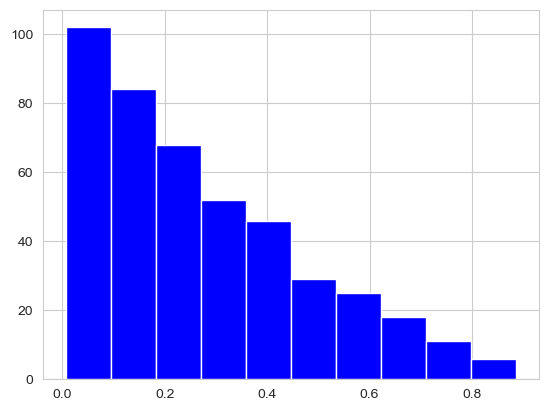

In [116]:
df_predict["probabilidad"].hist(color ="blue")
plt.show()

In [117]:
new_dataa = np.array([[0.624129,3.199742,2.267935], [0.2,3,3]])
mejor_modelo.predict_proba(new_dataa)



array([[0.15959574, 0.84040426],
       [0.04227591, 0.95772409]])

In [118]:
patron = r"Tapia-\w+"
patron = r"Moyano-\w+"
pat_tap =df_predict.index.str.contains(patron)

df_predict[pat_tap].sort_values("probabilidad",ascending=False).head()

,NF_total,pts_ganados,pts_netos,probabilidad
Moyano-Coello,0.760345,2.990714,2.230368,0.746
Moyano-Yanguas,0.761216,2.797924,2.036707,0.544
Moyano-JaviRico,0.638836,2.724225,2.085389,0.541
Moyano-Rubio,0.612366,2.680108,2.067742,0.507
Moyano-Di Nenno,0.732636,2.697921,1.965285,0.447


In [119]:
#parejas top5
def buscar_top(name):
    x = df_predict.loc[name]
    return x

top1= buscar_top("Tapia-Coello")

top2 = buscar_top("Galan-Lebron")
top3 = buscar_top("Stupa-Di Nenno")
top4 = buscar_top("Momo-Sanyo")
top5 = buscar_top("Paquito-Chingotto")
                  
tops5 = df_predict.loc[["Tapia-Coello", "Galan-Lebron", "Stupa-Di Nenno","Momo-Sanyo","Paquito-Chingotto"]]

#ops5 = tops5.rename({"NF_total":"No forzados"}, axis="column")
tops5.columns = ["no forzados", "pts_totales", "pts_netos","probabilidad"]

tops5 = tops5[["pts_totales","pts_netos", "no forzados", "probabilidad"]]

tops5["ranking"]= 1,2,3,4,5
tops5

,pts_totales,pts_netos,no forzados,probabilidad,ranking
Tapia-Coello,3.095960,2.442761,0.653199,0.865,1
Galan-Lebron,2.791439,1.871784,0.919655,0.430,2
Stupa-Di Nenno,2.855037,2.066339,0.788698,0.591,3
Momo-Sanyo,2.686124,1.790843,0.895281,0.330,4
Paquito-Chingotto,2.658249,1.781066,0.877183,0.313,5


In [154]:
#fx para sumar otro cluster mayor_prob43

def clus(msj):
    pat1 = r"(\w+)-\w+"
    pat2= r"\w+-(\w+)"
    jug1 = re.findall(pat1, msj)
    jug2 = re.findall(pat2, msj)
    
    
    if jug1[0] in cluster0:
        c1= "1"
    elif jug1[0] in cluster1:
        c1="2"
    else:
        c1="3"
        
    if jug2[0] in cluster0:
        c2= "1"
    elif jug2[0] in cluster1:
        c2="2"
    #elif jug2 in cluster2:
    else: 
        c2="3"
    
    return f"{c1} y {c2}"




mayor_prob43["cluster"] = mayor_prob43.index.to_series().apply(clus)

mayor_prob43.head(15)
    


,NF_total,pts_ganados,pts_netos,probabilidad,cluster
Lamperti-Coello,0.572173,3.092864,2.520691,0.887,3 y 3
Paquito-Coello,0.764272,3.184202,2.419930,0.877,3 y 3
Tapia-Coello,0.653199,3.095960,2.442761,0.865,3 y 3
Stupa-Coello,0.816407,3.147830,2.331422,0.840,3 y 3
Pincho-Coello,0.594590,2.984335,2.389745,0.816,3 y 3
Galan-Coello,0.792485,3.082584,2.290099,0.805,3 y 3
Momo-Coello,0.672026,2.991904,2.319878,0.789,1 y 3
Leal-Coello,0.716584,3.002467,2.285882,0.777,3 y 3
Lamperti-Yanguas,0.573044,2.900074,2.327030,0.761,3 y 1
Lamperti-JaviRico,0.450664,2.826376,2.375712,0.759,3 y 1


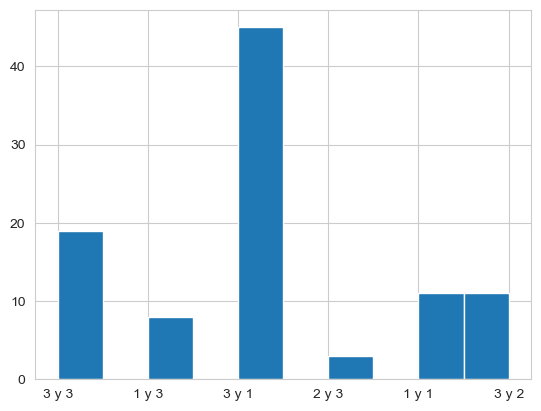

In [151]:
mayor_prob43["cluster"].hist()
plt.show()

porque no hay tantos jugadores que jueguen del lado derecho de la cancha y hagan muchos puntos. los top 10 deben ser 3y3